In [20]:
import numpy
import numpy as np
import itertools as it 
import gym
import torch
import torch.nn.functional as F 
import torch.nn as nn
from torch.autograd import Variable
from skimage import color
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt



In [3]:
#copy

class ScaleFloatFram(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float64)

def make_env(env_name):
    env = gym.make(env_name)
    return env
    #return ScaleFloatFram(env)


In [4]:
env_name = "CarRacing-v0"
env = make_env(env_name)
ob =env.reset()

/Users/roxanefischer/.local/share/virtualenvs/code-i1XZ64Tp/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Track generation: 1240..1554 -> 314-tiles track


In [5]:
#To understand
def one_step(i :int):
    action = env.action_space.sample()
    #action = [0,1,1]
    observation, reward, done, info = env.step(action)
    if (i%10==0):
        print(f" action : {action}")
        print(f"reward : {reward}")
        print(f"done : {done}")
        plt.show()
        plt.imshow(observation)
        print("------------------")



In [6]:
np.random.RandomState(42)
n_episode = 2
max_horizon = 100
batch_size = 3
gamma = 0.9 
num_frame_stack = 4
epsilon = 0.1

#direction frein acceleration
all_actions = np.array( [k for k in it.product([-1, 0, 1], [1, 0], [0.2, 0])])
nb_actions = len(all_actions)

In [7]:
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=3,H=96, W=96):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C,self.H, self.W)

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [8]:
class Q_model(nn.Module):
    """
    Build and return a PyTorch model implementing the architecture above.
    """

    def __init__(self, batch_size=1, nb_frames=4, output_dim=nb_actions, trainable=True):
        super(Q_model,self).__init__()
        self.model = nn.Sequential(
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                Unflatten(batch_size, nb_frames, 96, 96),
                #Unflatten(1, 3, 96, 96),
                nn.Conv2d(in_channels=4, out_channels=16, kernel_size=7, stride=3), #46
                nn.LeakyReLU(inplace=True, negative_slope=0.01),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2), #42
                nn.LeakyReLU(inplace=True, negative_slope=0.01),
                nn.MaxPool2d(kernel_size=2, stride=2), #21
                Flatten(),
                nn.Linear(288, 256),
                nn.LeakyReLU(inplace=True, negative_slope=0.01),
                nn.Linear(256, output_dim),)

            #nn.Linear(input_dim,48),
            #nn.LeakyReLU(0.01),
            #nn.Linear(48,48),
            #nn.LeakyReLU(0.01),
            #nn.Linear(48,output_dim)
            

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    def forward(self,x):
         return self.model(x)

torch.Size([2, 28224]) = 64 * 21 *21


In [9]:

def initialize_deque(obs,num_frame_stack=num_frame_stack):
    d = deque(maxlen=num_frame_stack)
    for i in range(num_frame_stack):
        d.appendleft(obs)
    return d

def stack_to_vector(deque : deque):
    array = np.array(deque)
    return torch.from_numpy(array).float()
    
def to_grey(obs):
    return color.rgb2gray(obs) 

def find_index(all_actions, action):
    for i in range(len(all_actions)):
        if (np.array_equal(all_actions[i],action)):
            return i


In [73]:

#optimizer = optim.Adam(Q.parameters(), lr=0.001, betas=(0.5, 0.999))
memory = list()

def main():
    for i_episode in range(n_episode):
        print(f"Episode nb : {i_episode}")
        observation = env.reset()
        d=initialize_deque(to_grey(observation))

        for i_step in range(max_horizon):
            stack = stack_to_vector(d)
            Q_current = Q((stack))
            #select the best action
            greedy_ind = np.argmax(Q_current.detach().numpy())
            action = all_actions[greedy_ind]
           
    
            #execute action
            obs_next, reward, done, info = env.step(action)
            d.appendleft(to_grey(obs_next))
            stack_next = stack_to_vector(d)
            #store trnasition
            memory.append({"st":stack,"at":action,"rt":reward,"st+1":stack_next})
            #sample minibatch
            selection = numpy.random.choice(memory, size=batch_size, replace=True)

            rewards=torch.empty(batch_size)
            #computed_rewards=torch.empty(batch_size)
            loss = 0.0
            optimizer.zero_grad()
            for m in range(batch_size):
                stack=selection[m]["st"]
                stack_next = selection[m]["st+1"]
                rewards[m]= selection[m]["rt"]
                if (done == False):
                    greedy_max = np.max(Q(stack_next).detach().numpy())
                    rewards[m] =+ gamma*greedy_max
                loss+= F.mse_loss(Q(stack), rewards[m])
            #loss= F.mse_loss(computed_rewards, rewards)

            loss.backward()
            #print(loss)
            #print()

    



In [10]:

np.random.RandomState(42)
n_episode = 20
max_horizon = 100
batch_size = 10
gamma = 0.9 
num_frame_stack = 4
epsilon = 0.1
learning_rate = 0.01

#direction frein acceleration
all_actions = np.array( [k for k in it.product([-1, 0, 1], [1, 0], [0.2, 0])])
nb_actions = len(all_actions)


In [15]:
tab_loss = list()
memory = list()
class Agent():
    def __init__(self):
        self.target_network = Q_model(batch_size=1, nb_frames=4, output_dim=nb_actions, trainable=True)
        self.estimate_network = Q_model(batch_size=1, nb_frames=4, output_dim=nb_actions, trainable=True)
        self.optimizer = optim.Adam(self.estimate_network.parameters(),lr=learning_rate)
        self.target_parameters = self.target_network.parameters()
        self.estimate_parameters = self.estimate_network.parameters()
        self.frame = None


        self.target_network.eval()
        self.estimate_network.train()

    def init_frame(self, obs,num_frame_stack=num_frame_stack):
        d = deque(maxlen=num_frame_stack)
        for i in range(num_frame_stack):
            d.appendleft(to_grey(obs))
        return d
    
    def reinitialisation_episode(self):
        observation = env.reset()
        self.frame = self.init_frame(observation)


    def update_target_network(self, tau = 0.1):
        for target_param, local_param in zip(self.target_network.parameters(),self.estimate_network.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
        #assert(len(self.target_parameters)==len(self.estimate_parameters))
       #for param in range(self.target_parameters):
                        
                        

    def take_action(self, eps):
        proba = np.random.uniform(0, 1)
        #print(proba)
        if (proba > eps) :
            #print("proba >eps ")
            with torch.no_grad():
                stack = stack_to_vector(self.frame)
                Q_current = self.estimate_network((stack))
                print(Q_current)
                #select the best action
                greedy_ind = np.argmax(Q_current.detach().numpy())
                action = all_actions[greedy_ind]
        else :
           # print("proba <eps ")
            action_ind = np.random.randint(0, nb_actions)
            action =  all_actions[action_ind]
        return action

    def learn_from_action(self, action):
        obs_next, reward, done, info = env.step(action)
        stack = stack_to_vector(self.frame)
        self.frame.appendleft(to_grey(obs_next))
        stack_next = stack_to_vector(self.frame)
        #store trnasition
        memory.append({"st":stack,"at":action, "rt":reward,"st+1":stack_next})
        #sample minibatch
        selection = numpy.random.choice(memory, size=batch_size, replace=True)

        loss_function = nn.MSELoss()

        # self.target_network.eval()
        # self.estimate_network.train()

        targets=torch.empty(batch_size)
        predicted=torch.empty(batch_size)

        for m in range(batch_size):
            action = selection[m]["at"]
            index_action = find_index(all_actions, action)
            with torch.no_grad():
                targets[m]= selection[m]["rt"]
                if (done == False):
                    stack_next = selection[m]["st+1"]
                    greedy_max = np.max(self.target_network(stack_next).detach().numpy())
                    targets[m] =+ gamma*greedy_max
                #loss+= F.mse_loss(Q(stack), rewards[m])
            stack = selection[m]["st"]
            #rint(f"index {index_action}")
            #print(len(predicted))
            #print(f"output size {len(self.estimate_network(stack)[0])}")
            #print(f"output size {len(self.target_network(stack))}")
            #print(self.estimate_network(stack))
            predicted[m] = self.estimate_network(stack)[0][index_action]
        
        loss = loss_function(predicted, targets)
        tab_loss.append(loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.update_target_network()







In [16]:
def run():
    agent = Agent()
    for i_episode in range(n_episode):
        print(f"ie episode : {i_episode}")
        agent.reinitialisation_episode()
        for i_step in range(max_horizon):
            action = agent.take_action(epsilon)
            agent.learn_from_action(action)



In [17]:
run()

ie episode : 0
Track generation: 1101..1380 -> 279-tiles track
tensor([[-0.0377,  0.0128, -0.0232,  0.0175,  0.0704,  0.0254,  0.0402,  0.0369,
         -0.0586,  0.0050, -0.0825,  0.0194]])
tensor([[ 0.1767, -0.4535,  0.0433, -0.2378,  3.8729, -0.1163, -0.0506,  0.1853,
         -0.3984,  0.1934,  0.1437, -0.2927]])
tensor([[-0.1769, -0.0058,  0.0957,  0.1597, -0.2075, -0.1767,  0.0952,  0.4067,
         -0.0086, -0.0598, -0.2838,  0.1456]])
tensor([[-0.1637, -0.0383,  0.2180, -0.0188,  0.2669, -0.2838,  0.3658, -0.2814,
          0.0208,  0.0022,  0.0075,  0.0290]])
tensor([[-0.1451,  0.0077,  0.0491,  0.0505,  0.2491, -0.2588, -0.1493, -0.1512,
         -0.0273, -0.0827, -0.0179,  0.0321]])
tensor([[-0.0378,  0.0422, -0.0304,  0.0985,  0.0008, -0.1414, -0.0626, -0.0356,
          0.0216, -0.0979, -0.0468,  0.0599]])
tensor([[ 0.0200,  0.1058,  0.1087,  0.0196, -0.1098, -0.0589,  0.0579,  0.0033,
          0.0275, -0.0615,  0.0212,  0.0463]])
tensor([[ 0.0293,  0.0489,  0.0681, -0.05

KeyboardInterrupt: 

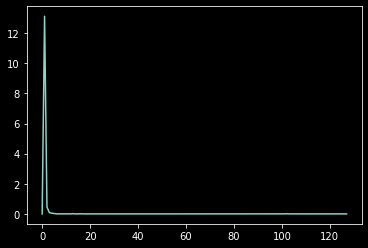

In [21]:
plt.plot(tab_loss)
